In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from peak_warming_calculator import *

## Define Functions

In [3]:
## SCC functions
from SCC_functions import *

In [4]:
def create_total_consumption_Pretis(years, g_ts, W_start_year=80):
    start_year = years[0]

    W = [W_start_year]
    W_previous_year = W_start_year
    for i in range(len(years) - 1):
        W_this_year = W_previous_year*np.exp(g_ts[i])
        W.append(W_this_year)
        W_previous_year = W_this_year
    
    W = np.asarray(W)
    return W

In [5]:
## calculate cost of perturbation due to carbon
## input: temperature profile, perturbed temperature profile, total consumption, and discount function

def SCC_calculator_Pretis(time_series_df_Pretis, size_of_perturbation):
    W = time_series_df_Pretis['W'].to_numpy()
    W_perturbed = time_series_df_Pretis['W perturbed'].to_numpy()
    discount_function = time_series_df_Pretis['discount function'].to_numpy()

    absolute_consumption_loss = W-W_perturbed
    discounted_consumption_loss = absolute_consumption_loss*discount_function
    area = sum(discounted_consumption_loss)
    SCC = area * 10 ** 12 / (size_of_perturbation * 10 ** 9)  # convert to dollar amount and normalise for 1 tCO2
    return SCC

In [78]:
# default settings
P0 = 50
P_50 = 120  # 187.5 * 0.7625000000000001
P_100 = 300  # 187.5

In [79]:
start_year = 2020
end_year = 3000

In [80]:
r_minus_g = 0.015

In [81]:
W_0 = 80
g_0 = 0.02
beta = 0.001

In [82]:
consumption_growth = g_0
consumption_discount = consumption_growth + r_minus_g

In [83]:
r = 0.03
s = 0.05

In [84]:
CO2_baseline = 40

In [85]:
## MACC functions and parameters

def abatement(P, P0=P0, P_50=P_50, r=r, s=s, P_100=P_100):  # 0.05
    if P0 >= P_50:
        print("P0 is greater than P_50")
    elif ((P_100-P0)/(P_50-P0))**(s/r) <= 2:
        print("MAC curve condition not satisfied")
    
    P_h = P0 + ((P_50 - P0) ** (-s / r) - 2 * (P_100 - P0) ** (-s / r)) ** (-r / s)
    Am = 1 + ((P_100 - P0) / (P_h - P0)) ** (-s / r)
    
    A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
    
    return A

## calculate emissions from forecasted abatement and CO2 baseline

def abatement_to_emissions(forecasted_abatement, CO2_baseline):
    CO2_emissions = CO2_baseline*(1-forecasted_abatement)
    
    return CO2_emissions

# Steps

## 0. Years and Initial Temperature Anomaly

In [86]:
start_year = 2020
end_year = 3000

years = create_years_array(start_year, end_year)
num_of_years = len(years)

In [87]:
## years to calculate SCC
first_perturbed_year = start_year
last_perturbed_year = 2500
year_of_perturbation = create_years_array(start_year, last_perturbed_year)

In [88]:
T_0 = 1.2

## 1. Create Unperturbed Temperature Profile

In [89]:
delta_T = 3
alpha = 0.02
T = create_geometric_T(years, T_0=T_0, alpha=alpha, delta_T=delta_T)

alternative functional form for above for the fast transition

## 2. Calculate SCC as a function of time for a range of years

In [90]:
T_TCRE_1 = 0.00045
k_s = 0.12
size_of_perturbation = 1

In [91]:
gamma = 2
D0 = 0.00236

In [92]:
# consumption_discount = 0.035
# consumption_discount = consumption_growth + 0.015

In [93]:
# peak_T_Nordhaus, output_df_Nordhaus = peak_warming_calculator(consumption_discount=g_0+r_minus_g,
#                                                                   consumption_growth=g_0,
#                                                                   gamma=gamma, D0=D0,
#                                                                   P_50=P_50, s=s, r=r, P_100=P_100,
#                                                                   start_year=start_year, end_year=end_year,
#                                                                   last_SCC_year=last_perturbed_year,
#                                                                   T_TCRE_1=T_TCRE_1, k_s=k_s,
#                                                                   T_0=T_0, delta_T=delta_T, alpha=alpha,
#                                                                   size_of_perturbation=size_of_perturbation,
#                                                                   CO2_baseline=CO2_baseline,
#                                                                   return_all_output=True)

In [94]:
# P0_Nordhaus = output_df_Nordhaus['SCC'].loc[2020]

In [95]:
# P0_Nordhaus

In [97]:
# consumption_discount = 0.035
# consumption_discount = consumption_growth + 0.015

SCC_list = []
SCC_list_actual = []

for j in range(len(year_of_perturbation)):
    T_perturbed = create_geometric_T_perturbed(years, T=T, SCC_year=year_of_perturbation[j], T_TCRE=T_TCRE_1*size_of_perturbation, k_s=k_s)   
    
    g = g_0 - beta*(T[:-1]**2-T_0**2)
    g_perturbed = g_0 - beta*(T_perturbed[:-1]**2-T_0**2)
    
    consumption_discount = g[j] + r_minus_g
#     consumption_discount = g_0 + r_minus_g
    discount_function = create_discount_function(years, year_of_perturbation[j], consumption_discount=consumption_discount)
    
    W = create_total_consumption_Pretis(years, g, W_start_year=W_0)
    W_perturbed = create_total_consumption_Pretis(years, g_perturbed, W_start_year=W_0)
    
    time_series_data_Pretis = {'years': years, 'W': W, 'W perturbed': W_perturbed, 'discount function': discount_function}
    time_series_df_Pretis = pd.DataFrame(data=time_series_data_Pretis).set_index('years')

    SCC = SCC_calculator_Pretis(time_series_df_Pretis, size_of_perturbation=size_of_perturbation)
    
    if j  == 0:
        SCC_0 = SCC
        print(SCC)
    SCC_list_actual.append(SCC)
    SCC_adjusted = SCC - SCC_0 + P0
#     print(SCC_adjusted)
    if SCC_adjusted < P_100:
        SCC_list.append(SCC_adjusted)
    else:
        SCC_list.append(P_100)
        break

363.6474995361756


In [98]:
SCC_array = np.asarray(SCC_list)  # convert to numpy array

In [99]:
SCC_list

[50.0,
 61.49268728937551,
 73.29026747443066,
 85.3972269242247,
 97.81804593821875,
 110.55719626387628,
 123.61913881523702,
 137.00832154436733,
 150.72917744511517,
 164.78612270400544,
 179.1835550356805,
 193.9258520969209,
 209.01737011867795,
 224.46244257606702,
 240.26537910536547,
 256.43046448488724,
 272.96195774025193,
 289.8640914626335,
 300]

Text(0, 0.5, 'SCC ($)')

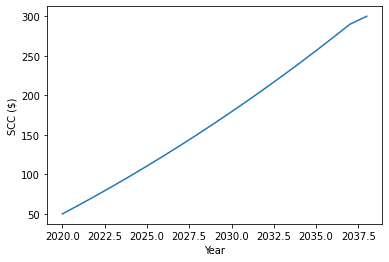

In [100]:
plt.plot(year_of_perturbation[:len(SCC_array)], SCC_array)
plt.xlabel("Year")
plt.ylabel("SCC ($)")

In [101]:
SCC_array

array([ 50.        ,  61.49268729,  73.29026747,  85.39722692,
        97.81804594, 110.55719626, 123.61913882, 137.00832154,
       150.72917745, 164.7861227 , 179.18355504, 193.9258521 ,
       209.01737012, 224.46244258, 240.26537911, 256.43046448,
       272.96195774, 289.86409146, 300.        ])

### Check 100% abatement has been achieved!

In [102]:
if SCC_array[-1] < P_100:
    print("P_100 not achieved by achieved by final perturbed year")

In [103]:
SCC_forecasted = []

for i in range(num_of_years):
    if i < len(SCC_array):
        SCC_forecasted.append(SCC_array[i])
    else:
#         SCC_forecasted.append(SCC_array[-1])
        SCC_forecasted.append(P_100)

SCC_forecasted = np.array(SCC_forecasted)

In [104]:
# SCC_forecasted

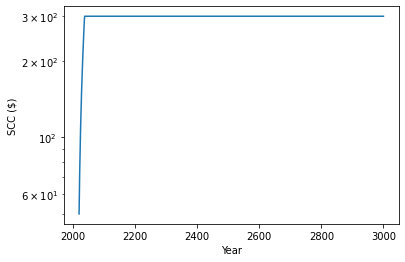

In [105]:
plt.plot(years, SCC_forecasted)
plt.xlabel("Year")
plt.ylabel("SCC ($)")
plt.yscale("log")

## 3. Abatement as a function of time

In [106]:
# P0 = SCC_forecasted[0]

In [107]:
forecasted_abatement = abatement(P=SCC_forecasted)  # , r=consumption_discount

/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_68130/2369457626.py:12: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


problems with certain values due to constraints of the model

Text(0, 0.5, 'Abatement')

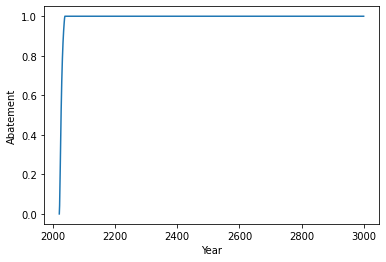

In [108]:
plt.plot(years, forecasted_abatement)
plt.xlabel("Year")
plt.ylabel("Abatement")

## 4. Abatement to emissions

In [109]:
forecasted_emissions = abatement_to_emissions(forecasted_abatement, CO2_baseline)

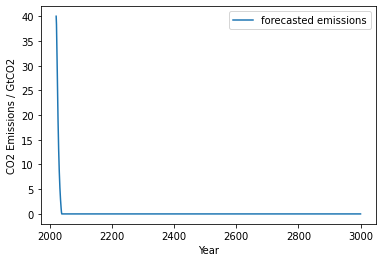

In [110]:
# plt.plot(ssp245_CO2_past, label="historical emissions")
plt.plot(years, forecasted_emissions, label="forecasted emissions")
plt.xlabel("Year")
plt.ylabel("CO2 Emissions / GtCO2")
plt.legend()

## 5. Cumulative Emissions to Temperature Change

In [111]:
cumulative_emissions_array = np.append(np.zeros(1), np.cumsum(forecasted_emissions)[:-1])

In [112]:
temperature_change = T_TCRE_1*cumulative_emissions_array

In [113]:
max(temperature_change)

0.12746106556604486

In [114]:
T_forecast_iteration0 = T_0 + temperature_change
# T_forecast_iteration0_plateau = T_2019 + temperature_change_plateau

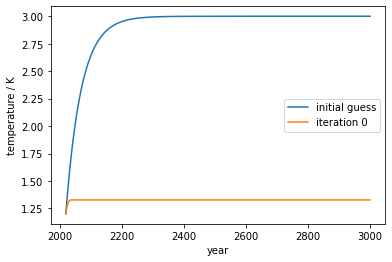

In [115]:
plt.plot(years, T, label="initial guess")
plt.plot(years, T_forecast_iteration0, label="iteration 0")
# plt.plot(T_forecast_years, T_forecast_iteration0_plateau, label="iteration 0 plateau")
plt.xlabel("year")
plt.ylabel("temperature / K")
plt.legend()

# Iterating Further

In [117]:
# T_forecast_first_loop = T_forecast_iteration0_plateau
# T_forecast_iteration = T_forecast_iteration0_plateau

In [118]:
T_forecast_first_loop = T_forecast_iteration0
T_forecast_iteration = T_forecast_iteration0

357.99708712808274
362.51484773864195


/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_68130/2369457626.py:12: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


361.84120827926085
2


/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_68130/2369457626.py:12: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_68130/2369457626.py:12: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


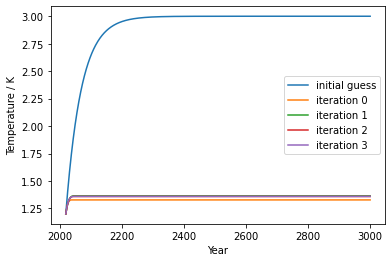

In [119]:
num_of_iterations = 99

first_perturbed_year = start_year

year_of_perturbation = np.arange(first_perturbed_year, last_perturbed_year+1)

plt.plot(years, T, label="initial guess")
plt.plot(years, T_forecast_first_loop, label="iteration 0")

for k in range(num_of_iterations):
#     T_iteration = np.concatenate([T_gas_df['CO2_best'],T_forecast_iteration[1:]])

    SCC_list = []
    SCC_list_actual = []

    for j in range(len(year_of_perturbation)):

        T_perturbed = create_geometric_T_perturbed(years, T=T_forecast_iteration, SCC_year=year_of_perturbation[j], T_TCRE=T_TCRE_1*size_of_perturbation, k_s=k_s)
    
        g = g_0 - beta*(T_forecast_iteration[:-1]**2-T_0**2)
        g_perturbed = g_0 - beta*(T_perturbed[:-1]**2-T_0**2)

        consumption_discount = g[j] + r_minus_g
#         consumption_discount = g_0 + r_minus_g
        discount_function = create_discount_function(years, year_of_perturbation[j], consumption_discount=consumption_discount)

        W = create_total_consumption_Pretis(years, g, W_start_year=W_0)
        W_perturbed = create_total_consumption_Pretis(years, g_perturbed, W_start_year=W_0)

        time_series_data_Pretis = {'years': years, 'W': W, 'W perturbed': W_perturbed, 'discount function': discount_function}
        time_series_df_Pretis = pd.DataFrame(data=time_series_data_Pretis).set_index('years')

        SCC = SCC_calculator_Pretis(time_series_df_Pretis, size_of_perturbation=size_of_perturbation)

        if j  == 0:
            SCC_0 = SCC
            print(SCC)
        SCC_list_actual.append(SCC)
        SCC_adjusted = SCC - SCC_0 + P0
        if SCC_adjusted < P_100:
            SCC_list.append(SCC_adjusted)
        else:
            SCC_list.append(P_100)
            break

    SCC_array = np.asarray(SCC_list)

    SCC_forecasted = []

    for i in range(num_of_years):
        if i < len(SCC_array):
            SCC_forecasted.append(SCC_array[i])
        else:
            SCC_forecasted.append(P_100)

    SCC_forecasted = np.array(SCC_forecasted)

    P0 = SCC_forecasted[0]

    forecasted_abatement = abatement(P=SCC_forecasted)
    forecasted_emissions = abatement_to_emissions(forecasted_abatement, CO2_baseline)

    cumulative_emissions_array = np.append(np.zeros(1), np.cumsum(forecasted_emissions)[:-1])

    temperature_change = T_TCRE_1*cumulative_emissions_array
    
    T_forecast_iteration = T_0 + temperature_change
    
    plt.plot(years, T_forecast_iteration, label="iteration "+str(k+1))
    
    if k == 0:
        peak_T = max(T_forecast_iteration)
    else:
        previous_peak_T = peak_T
        peak_T = max(T_forecast_iteration)
        if abs(peak_T - previous_peak_T) < 0.005:
            print(k)
            break
    
    if k == num_of_iterations - 1:
        print("convergence condition not achieved")
        print(f"{consumption_discount=}")
        print(f"{consumption_growth=}")
        print(f"{P_50=}")
        print(f"{s=}")
        print(f"{r=}")
        print(f"{P_100=}")

plt.xlabel("Year")
plt.ylabel("Temperature / K")
plt.legend()

***this is fairly analogous to the Newton-Raphson Method***
- the initial temperature profile is essentially just a starting guess; getting pushed toward temperature profile solution
- could stop the iterations when the difference between two consecutive lines is small

In [120]:
## peak Temperature
max(T_forecast_iteration)

1.3594938864699835

under default settings: 1.3985211364163126

In [124]:
SCC_forecasted-P0+SCC_0

array([361.84120828, 371.50369393, 381.34867209, 391.29721711,
       401.30055949, 411.33151838, 421.37913954, 431.44350127,
       441.53147756, 451.65371119, 461.8226387 , 472.05128677,
       482.35258372, 492.7389952 , 503.2223551 , 513.81380963,
       524.52382352, 535.36221798, 546.33822231, 557.4605287 ,
       568.73734466, 580.17644035, 591.7851884 , 603.57059433,
       611.84120828, 611.84120828, 611.84120828, 611.84120828,
       611.84120828, 611.84120828, 611.84120828, 611.84120828,
       611.84120828, 611.84120828, 611.84120828, 611.84120828,
       611.84120828, 611.84120828, 611.84120828, 611.84120828,
       611.84120828, 611.84120828, 611.84120828, 611.84120828,
       611.84120828, 611.84120828, 611.84120828, 611.84120828,
       611.84120828, 611.84120828, 611.84120828, 611.84120828,
       611.84120828, 611.84120828, 611.84120828, 611.84120828,
       611.84120828, 611.84120828, 611.84120828, 611.84120828,
       611.84120828, 611.84120828, 611.84120828, 611.84